# Perceptron as an ML model

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [59]:
class Perceptron:
    def __init__(self, learning_rate=0.1, n_epochs=10):
        """
        Initialize the Perceptron classifier.

        Parameters:
        learning_rate : float, optional (default=0.1)
            Learning rate (between 0.0 and 1.0).
        n_epochs : int, optional (default=10)
            Number of passes over the training dataset.
        """
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.w_ = None  # Weights after fitting
        self.b_ = None  # Bias term after fitting

    def fit(self, X, y):
        """
        Fit training data.

        Parameters:
        X : array-like, shape = [n_samples, n_features]
            Training vectors.
        y : array-like, shape = [n_samples]
            Target values (0 or 1).

        Returns:
        self : object
        """
        n_samples, n_features = X.shape
        self.w_ = np.zeros(n_features)
        self.b_ = 0.0

        for epoch in range(self.n_epochs):
            for idx in range(n_samples):
                # Compute activation
                activation = np.dot(X[idx], self.w_) + self.b_
                # Make a prediction
                y_pred = 1 if activation >= 0 else 0
                # Update weights and bias if there is an error
                e = y[idx] - y_pred
                self.w_ += self.learning_rate * e * X[idx]
                self.b_ += self.learning_rate * e
        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters:
        X : array-like, shape = [n_samples, n_features]
            Input samples.

        Returns:
        y_pred : array, shape = [n_samples]
            Predicted class labels.
        """
        activation = np.dot(X, self.w_) + self.b_
        y_pred = np.where(activation >= 0, 1, 0)
        return y_pred

In [60]:
def generate_samples(n_samples=100, n_features=2, n_classes=2, class_sep=1.0, random_state=None):
    """
    Generate synthetic classification dataset.

    Parameters:
    n_samples : int, optional (default=100)
        Number of samples.
    n_features : int, optional (default=2)
        Number of features.
    n_classes : int, optional (default=2)
        Number of classes.
    class_sep : float, optional (default=1.0)
        The factor multiplying the hypercube size. Larger values spread out the clusters/classes.
    random_state : int or None, optional (default=None)
        Determines random number generation for dataset creation.

    Returns:
    X : array of shape [n_samples, n_features]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for class membership of each sample.
    """
    X, y = make_classification(n_samples=n_samples, n_features=n_features,
                               n_informative=n_features, n_redundant=0, n_repeated=0,
                               n_classes=n_classes, class_sep=class_sep,
                               random_state=random_state)
    return X, y

In [61]:
# Visualize decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict(grid).reshape(xx.shape)
    plt.contourf(xx, yy, probs, alpha=0.2, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
    plt.title('Perceptron Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

In [ ]:
# Generate a synthetic dataset
X, y = generate_samples(n_samples=200, n_features=2, class_sep=1.5, random_state=42)

# Visualize the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
plt.title('Synthetic Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
# List of epochs to run
epochs_list = [10, 100, 1000, 10000]

for n_epochs in epochs_list:
    print(f'Running with n_epochs = {n_epochs}')
    
    # Initialize and train the perceptron model
    perceptron = Perceptron(learning_rate=0.1, n_epochs=n_epochs)
    perceptron.fit(X, y)
    
    # Predict on the training data
    y_pred = perceptron.predict(X)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred == y)
    print(f'Training accuracy: {accuracy * 100:.2f}%')
    
    # Plot the decision boundary
    plot_decision_boundary(perceptron, X, y)
    print('---')

# Capacity (Theory)

In [ ]:
import numpy as np
from math import log, lgamma, exp
import matplotlib.pyplot as plt

def comb_log(n, k):
    """
    Compute the logarithm of combinations C(n, k)
    using logarithms to avoid overflow.
    """
    return lgamma(n + 1) - lgamma(k + 1) - lgamma(n - k + 1)

def capacity_ratio(P, N):
    """
    Calculate the capacity ratio C(P, N)/2^P of a perceptron model.

    Parameters:
    P : int
        Number of points.
    N : int
        Number of features.

    Returns:
    ratio : float
        Capacity ratio C(P, N)/2^P.
    """
    log2 = log(2)
    if P <= N + 1:
        log_C = P * log2  # log(2^P) = P * log(2)
        C_over_2P = exp(log_C - P * log2)  # Should be 1.0
    else:
        # Compute log C(P, N)
        terms = []
        for k in range(N + 1):
            log_term = comb_log(P - 1, k)
            terms.append(log_term)
        max_log_term = max(terms)
        # Compute log sum exp
        log_sum_exp = max_log_term + log(sum(exp(t - max_log_term) for t in terms))
        log_C = log2 + log_sum_exp  # Multiply by 2, so add log(2)
        # Compute log(C/2^P)
        log_C_over_2P = log_C - P * log2
        C_over_2P = exp(log_C_over_2P)
    return C_over_2P

# Define N values
N_values = np.arange(5, 21)   # N from 1 to 20

# Prepare lists to store ratios and P/N values
ratios = []
PN_ratios = []

# Calculate the capacity ratios for different P and N
for N in N_values:
    P_values = np.arange(0, 10 * N + 1)  # P from 0 to 2N
    for P in P_values:
        if P == 0:
            # Handle the case when P = 0
            ratio = 1.0  # C(0, N)/2^0 = 1/1 = 1
            PN_ratio = 0
        else:
            C_over_2P = capacity_ratio(P, N)
            ratio = C_over_2P
            PN_ratio = P / N
        ratios.append(ratio)
        PN_ratios.append(PN_ratio)

# Convert lists to numpy arrays for plotting
ratios = np.array(ratios)
PN_ratios = np.array(PN_ratios)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.scatter(PN_ratios, ratios, s=10, alpha=0.7, edgecolor='k')
plt.title('Capacity Ratio $C(P, N)/2^P$ vs. $P/N$ for Perceptron Model')
plt.xlabel('$P/N$')
plt.ylabel('$C(P, N)/2^P$')
plt.grid(True)
plt.show()


# Convergence

In [65]:
import numpy as np

def perceptron(X, y0, max_epochs=1000):
    """
    Perceptron learning algorithm.

    Parameters:
    X : numpy array of shape (N, P)
        The input samples, where N is the number of features,
        and P is the number of samples.
    y0 : numpy array of shape (P,)
        The corresponding labels (+1 or -1).
    max_epochs : int, optional (default=1000)
        The maximum number of epochs to run.

    Returns:
    w : numpy array of shape (N,)
        The final weight vector.
    converged : bool
        True if the algorithm converged, False otherwise.
    epochs : int
        The number of epochs run.
    """
    N, P = X.shape
    w = np.zeros(N)  # Initialize weight vector
    epochs = 0
    converged = False

    while epochs < max_epochs:
        errors = 0
        for i in range(P):
            x_i = X[:, i]  # Sample i (shape: N,)
            y_i = y0[i]    # Label for sample i
            activation = np.dot(w, x_i)
            if y_i * activation <= 0:
                # Misclassified sample, update weights
                w += y_i * x_i
                errors += 1
        epochs += 1
        if errors == 0:
            # No misclassifications in this epoch
            converged = True
            break
    return w, converged, epochs


In [66]:
def generate_data(N, P):
    """
    Generate random binary inputs and outputs for testing.

    Parameters:
    N : int
        Number of features.
    P : int
        Number of samples.

    Returns:
    X : numpy array of shape (N, P)
        Input samples.
    y0 : numpy array of shape (P,)
        Corresponding labels (+1 or -1).
    """
    # Random inputs in [-1, 1]
    X = np.random.uniform(-1, 1, (N, P))
    # Generate a random weight vector to create linearly separable data
    true_w = np.random.randn(N)
    # Assign labels based on the sign of the projection
    y0 = np.sign(np.dot(true_w, X))
    # Replace zeros in y0 with 1 (if any)
    y0[y0 == 0] = 1
    return X, y0


In [ ]:
# Parameters
N = 2  # Number of features
P = 30  # Number of samples

# Generate data
X, y0 = generate_data(N, P)

# Visualize the dataset
plt.scatter(X.T[:, 0], X.T[:, 1], c=y0, cmap='bwr', edgecolor='k')
plt.title('Synthetic Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Run the perceptron algorithm
w, converged, epochs = perceptron(X, y0)

# Print results
print(f"Converged: {converged}")
print(f"Number of epochs: {epochs}")
print(f"Final weight vector:\n{w}")

In [55]:
def run_experiments(N_values, P_values, n_repeats=50, max_epochs=1000):
    """
    Run experiments to investigate perceptron convergence.

    Parameters:
    N_values : list
        List of feature counts to test.
    P_values : list
        List of sample counts to test.
    n_repeats : int
        Number of repetitions for each (N, P) combination.
    max_epochs : int
        Maximum number of epochs for the perceptron algorithm.

    Returns:
    results : dict
        Dictionary containing convergence rates and average epochs.
    """
    results = {}
    for N in N_values:
        for P in P_values:
            converged_counts = 0
            total_epochs = 0
            for _ in range(n_repeats):
                X, y0 = generate_data(N, P)
                w, converged, epochs = perceptron(X, y0, max_epochs)
                if converged:
                    converged_counts += 1
                    total_epochs += epochs
            convergence_rate = converged_counts / n_repeats
            avg_epochs = total_epochs / converged_counts if converged_counts > 0 else None
            results[(N, P)] = {
                'convergence_rate': convergence_rate,
                'average_epochs': avg_epochs
            }
            print(f"N={N}, P={P}, Convergence Rate={convergence_rate*100:.2f}%, Average Epochs={avg_epochs}")
    return results


In [ ]:
# Define ranges for N and P
N_values = [5, 10, 15]
P_values = [10, 20, 30]

# Run experiments
results = run_experiments(N_values, P_values, n_repeats=50, max_epochs=1000)


In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting
N_list = []
P_list = []
convergence_rates = []
for (N, P), stats in results.items():
    N_list.append(N)
    P_list.append(P)
    convergence_rates.append(stats['convergence_rate'])

# Convert to numpy arrays
N_array = np.array(N_list)
P_array = np.array(P_list)
convergence_rates = np.array(convergence_rates)

# Create a scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(P_array / N_array, convergence_rates * 100, c=N_array, cmap='viridis', edgecolor='k')
plt.colorbar(scatter, label='Number of Features (N)')
plt.xlabel('$P/N$')
plt.ylabel('Convergence Rate (%)')
plt.title('Perceptron Convergence Rate vs. $P/N$')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def perceptron(X, y0, max_epochs=1000):
    N, P = X.shape
    w = np.zeros(N)
    epochs = 0
    converged = False

    while epochs < max_epochs:
        errors = 0
        for i in range(P):
            x_i = X[:, i]
            y_i = y0[i]
            activation = np.dot(w, x_i)
            if y_i * activation <= 0:
                w += y_i * x_i
                errors += 1
        epochs += 1
        if errors == 0:
            converged = True
            break
    return w, converged, epochs

def generate_linearly_separable_samples(N, P):
    X = np.random.uniform(-1, 1, (N, P))
    true_w = np.random.randn(N)
    y0 = np.sign(np.dot(true_w, X))
    y0[y0 == 0] = 1
    return X, y0

def run_experiments(N_values, P=10, n_repeats=50, max_epochs=1000):
    avg_epochs_list = []
    for N in N_values:
        total_epochs = 0
        converged_runs = 0
        for _ in range(n_repeats):
            X, y0 = generate_linearly_separable_samples(N, P)
            w, converged, epochs = perceptron(X, y0, max_epochs)
            if converged:
                total_epochs += epochs
                converged_runs += 1
            else:
                total_epochs += max_epochs
        avg_epochs = total_epochs / n_repeats
        avg_epochs_list.append(avg_epochs)
        print(f"N={N}, Average Epochs till Convergence: {avg_epochs:.2f}")
    return avg_epochs_list

# Parameters
N_values = [10, 20, 50, 100]
P = 10
n_repeats = 50
max_epochs = 1000

# Run experiments
avg_epochs_list = run_experiments(N_values, P, n_repeats, max_epochs)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(N_values, avg_epochs_list, marker='o')
plt.title('Average Epochs till Convergence vs. Number of Features (N)')
plt.xlabel('Number of Features (N)')
plt.ylabel('Average Epochs till Convergence')
plt.grid(True)
plt.show()


# General Position

General position means, no N+1 points are in N-1 subspace. For example, when N = 2, no 3 points are in a line.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_general_position_data(N, P):
    X = np.random.uniform(-1, 1, (N, P))
    y0 = np.random.choice([-1, 1], size=P)
    return X, y0

def perceptron(X, y0, max_epochs=1000):
    N, P = X.shape
    w = np.zeros(N)
    epochs = 0
    converged = False
    while epochs < max_epochs:
        errors = 0
        for i in range(P):
            x_i = X[:, i]
            y_i = y0[i]
            activation = np.dot(w, x_i)
            if y_i * activation <= 0:
                w += y_i * x_i
                errors += 1
        epochs += 1
        if errors == 0:
            converged = True
            break
    return w, converged, epochs

def run_experiments_fixed_N(N, P_values, n_repeats=50, max_epochs=1000):
    results = {}
    for P in P_values:
        epochs_list = []
        converged_runs = 0
        for _ in range(n_repeats):
            X, y0 = generate_general_position_data(N, P)
            _, converged, epochs = perceptron(X, y0, max_epochs)
            if converged:
                converged_runs += 1
                epochs_list.append(epochs)
            else:
                epochs_list.append(max_epochs)
        convergence_rate = converged_runs / n_repeats
        avg_epochs = np.mean(epochs_list)
        std_epochs = np.std(epochs_list)
        results[P] = {
            'convergence_rate': convergence_rate,
            'average_epochs': avg_epochs,
            'std_epochs': std_epochs
        }
        print(f"P={P}, Convergence Rate: {convergence_rate*100:.2f}%, Average Epochs: {avg_epochs:.2f}, Std Dev: {std_epochs:.2f}")
    return results

# Parameters
N = 10
P_values = range(int(N / 2), 5 * N + 1, N//2)  # P from N to 6N in steps of N/2
n_repeats = 50
max_epochs = 1000

# Run experiments
results = run_experiments_fixed_N(N, P_values, n_repeats, max_epochs)

# Extract data for plotting
P_list = list(results.keys())
PN_ratios = [P / N for P in P_list]
convergence_rates = [results[P]['convergence_rate'] * 100 for P in P_list]
average_epochs = [results[P]['average_epochs'] for P in P_list]
std_epochs = [results[P]['std_epochs'] for P in P_list]

# Plotting Convergence Rate
plt.figure(figsize=(10, 6))
plt.plot(PN_ratios, convergence_rates, marker='o')
plt.title(f'Perceptron Convergence Rate vs. P/N (N={N})')
plt.xlabel('$P/N$')
plt.ylabel('Convergence Rate (%)')
plt.grid(True)
plt.show()

# Plotting Average Epochs with Error Bars
plt.figure(figsize=(10, 6))
plt.errorbar(PN_ratios, average_epochs, yerr=std_epochs, fmt='o-', ecolor='r', capsize=5)
plt.title(f'Average Epochs till Convergence vs. P/N (N={N})')
plt.xlabel('$P/N$')
plt.ylabel('Average Epochs')
plt.grid(True)
plt.show()

# Margin

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_general_position_data(N, P):
    X = np.random.uniform(-1, 1, (N, P))
    y0 = np.random.choice([-1, 1], size=P)
    return X, y0

def perceptron(X, y0, max_epochs=1000):
    N, P = X.shape
    w = np.zeros(N)
    epochs = 0
    converged = False
    while epochs < max_epochs:
        errors = 0
        for i in range(P):
            x_i = X[:, i]
            y_i = y0[i]
            activation = np.dot(w, x_i)
            if y_i * activation <= 0:
                w += y_i * x_i
                errors += 1
        epochs += 1
        if errors == 0:
            converged = True
            break
    margin = None
    if converged:
        # Calculate the margin δ
        norm_w = np.linalg.norm(w)
        margins = (y0 * np.dot(w, X)) / norm_w
        margin = np.min(margins)
    return w, converged, epochs, margin

def run_experiments_with_margins(N_values, P_values, n_repeats=50, max_epochs=1000):
    margins_dict = {}
    for N in N_values:
        for P in P_values:
            margins = []
            converged_runs = 0
            for _ in range(n_repeats):
                X, y0 = generate_general_position_data(N, P)
                w, converged, epochs, margin = perceptron(X, y0, max_epochs)
                if converged and margin is not None:
                    margins.append(margin)
                    converged_runs += 1
            if converged_runs > 0:
                margins_dict[(N, P)] = margins
                print(f"N={N}, P={P}, Converged Runs: {converged_runs}/{n_repeats}")
            else:
                print(f"N={N}, P={P}, No converged runs.")
    return margins_dict

def plot_margin_histograms(margins_dict):
    for key, margins in margins_dict.items():
        N, P = key
        plt.figure(figsize=(8, 6))
        plt.hist(margins, bins=10, edgecolor='black', alpha=0.7)
        plt.title(f'Histogram of Margins for N={N}, P={P}')
        plt.xlabel('Margin δ')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()






In [108]:
# Parameters
N_values = [10]
P_values = [int(N * k / 5) for k in range(1, 11)]  # P = 0.2N, 0.4N, ..., 2N
n_repeats = 10 ** 3
max_epochs = 1000

N=10, P=2, Converged Runs: 1000/1000
N=10, P=4, Converged Runs: 1000/1000
N=10, P=6, Converged Runs: 1000/1000
N=10, P=8, Converged Runs: 1000/1000
N=10, P=10, Converged Runs: 999/1000
N=10, P=12, Converged Runs: 993/1000
N=10, P=14, Converged Runs: 940/1000
N=10, P=16, Converged Runs: 790/1000
N=10, P=18, Converged Runs: 646/1000
N=10, P=20, Converged Runs: 445/1000


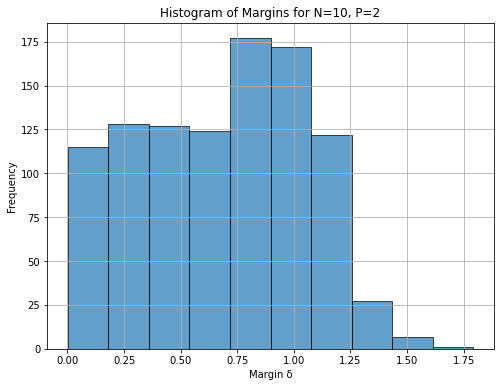

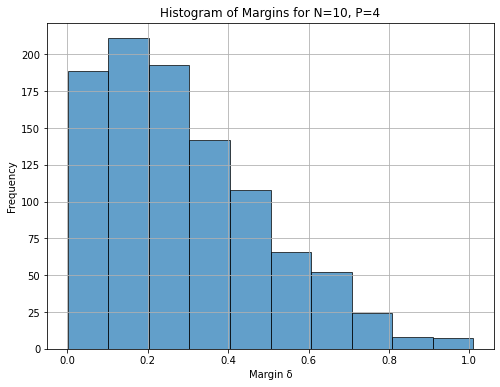

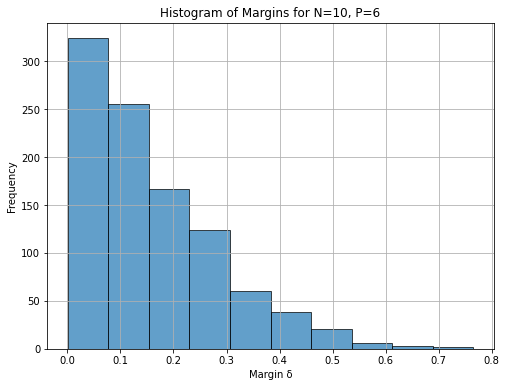

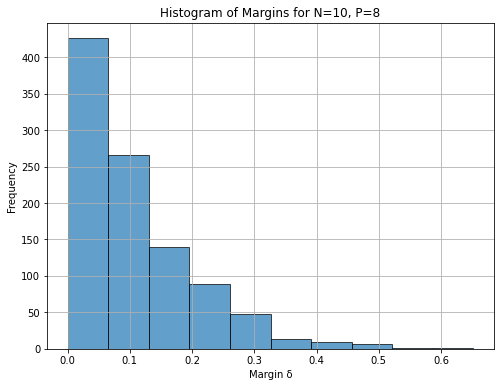

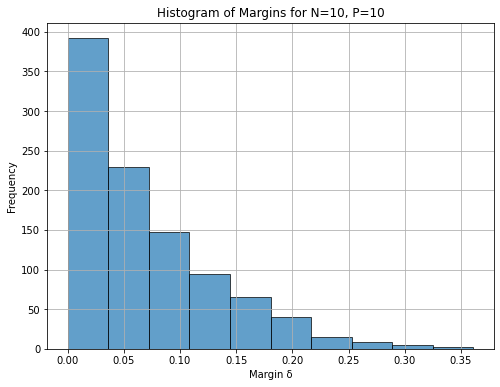

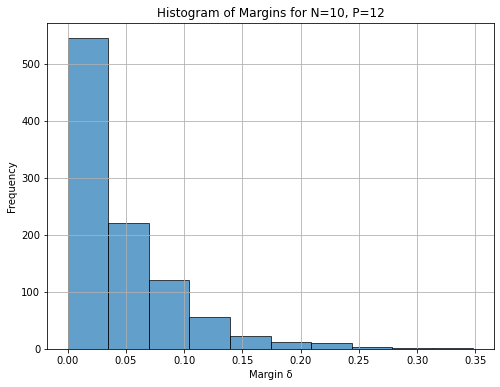

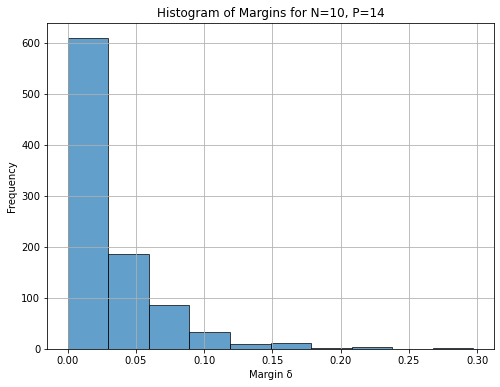

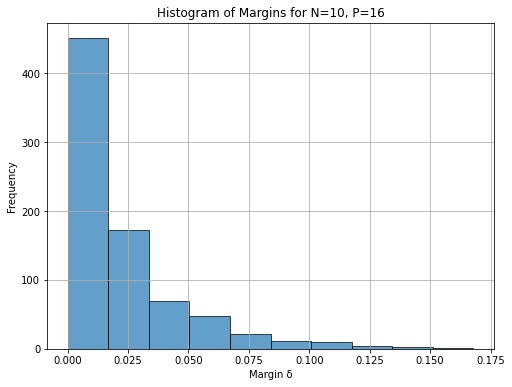

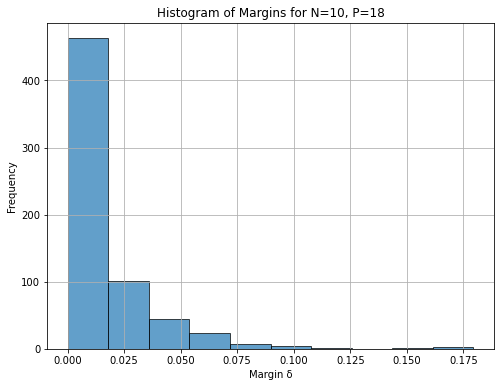

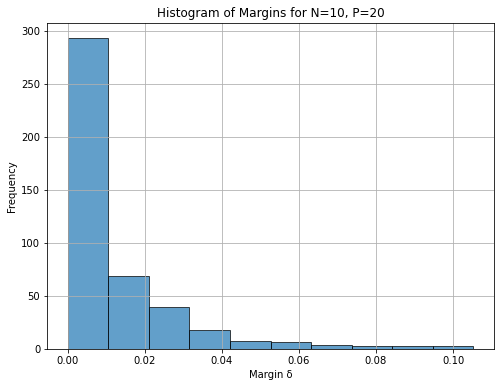

In [109]:
# Run experiments
margins_dict = run_experiments_with_margins(N_values, P_values, n_repeats, max_epochs)

# Plot histograms
plot_margin_histograms(margins_dict)

In [116]:
# Parameters
N_values = [20]
P_values = [int(20 * k / 5) for k in range(1, 11)]  # P = 0.2N, 0.4N, ..., 2N
n_repeats = 10 ** 3
max_epochs = 1000

N=20, P=4, Converged Runs: 1000/1000
N=20, P=8, Converged Runs: 1000/1000
N=20, P=12, Converged Runs: 1000/1000
N=20, P=16, Converged Runs: 1000/1000
N=20, P=20, Converged Runs: 1000/1000
N=20, P=24, Converged Runs: 1000/1000
N=20, P=28, Converged Runs: 979/1000
N=20, P=32, Converged Runs: 885/1000
N=20, P=36, Converged Runs: 666/1000
N=20, P=40, Converged Runs: 422/1000


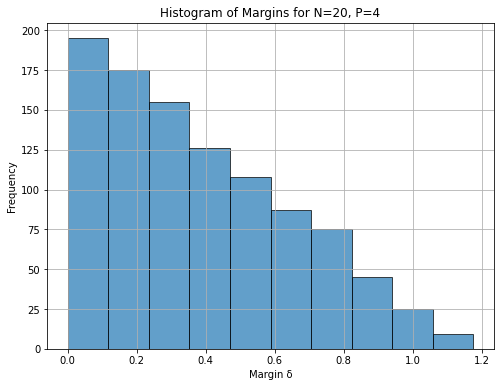

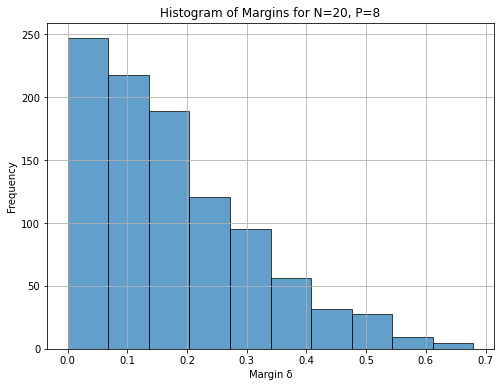

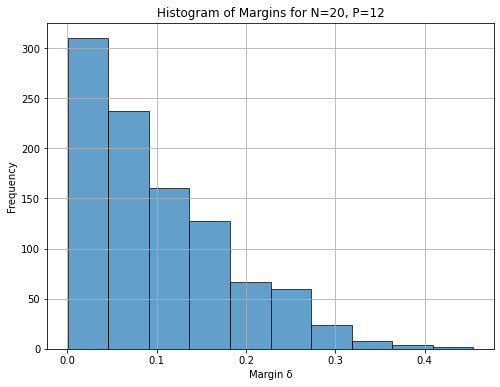

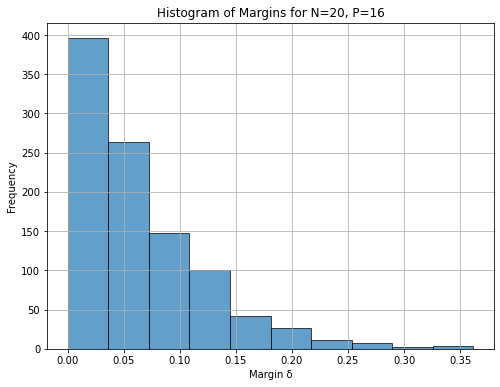

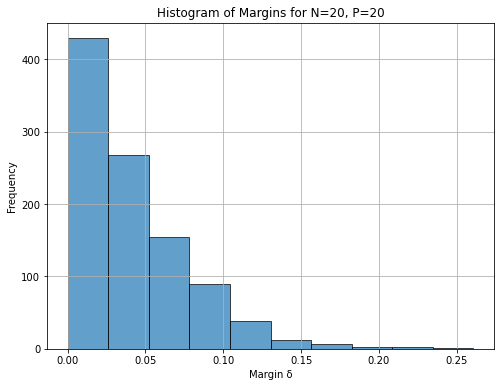

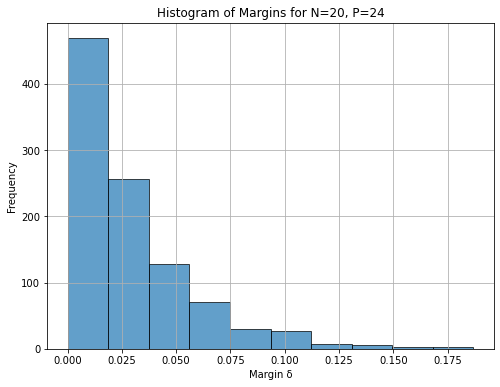

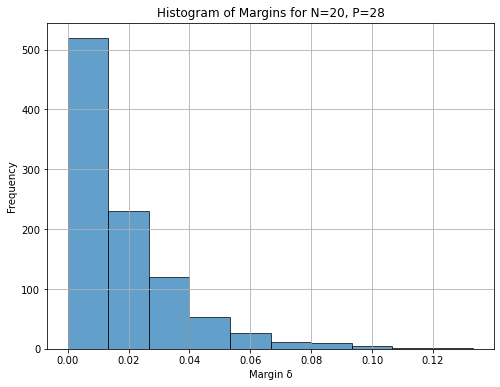

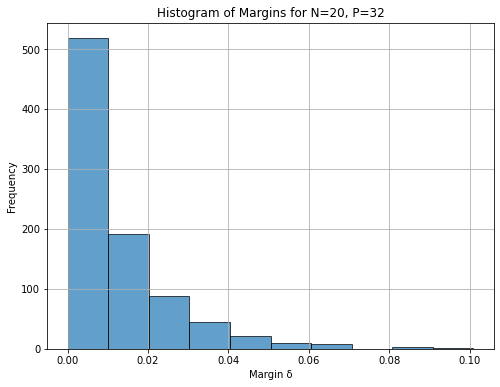

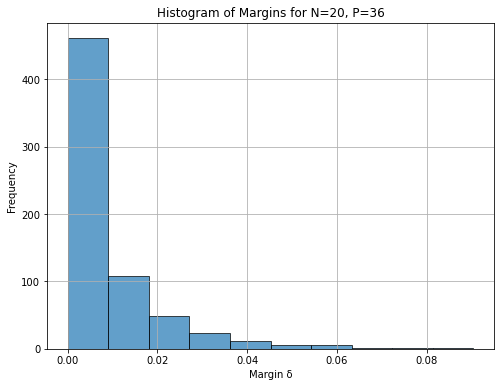

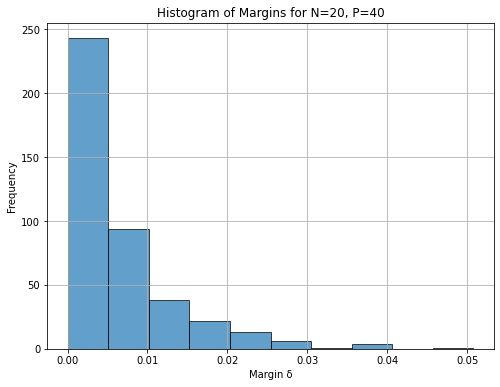

In [117]:
# Run experiments
margins_dict = run_experiments_with_margins(N_values, P_values, n_repeats, max_epochs)

# Plot histograms
plot_margin_histograms(margins_dict)

In [120]:
# Parameters
N_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
P_values = [20]  # P = 0.2N, 0.4N, ..., 2N
n_repeats = 10 ** 3
max_epochs = 1000

N=10, P=20, Converged Runs: 439/1000
N=20, P=20, Converged Runs: 1000/1000
N=30, P=20, Converged Runs: 1000/1000
N=40, P=20, Converged Runs: 1000/1000
N=50, P=20, Converged Runs: 1000/1000
N=60, P=20, Converged Runs: 1000/1000
N=70, P=20, Converged Runs: 1000/1000
N=80, P=20, Converged Runs: 1000/1000
N=90, P=20, Converged Runs: 1000/1000
N=100, P=20, Converged Runs: 1000/1000
N=110, P=20, Converged Runs: 1000/1000


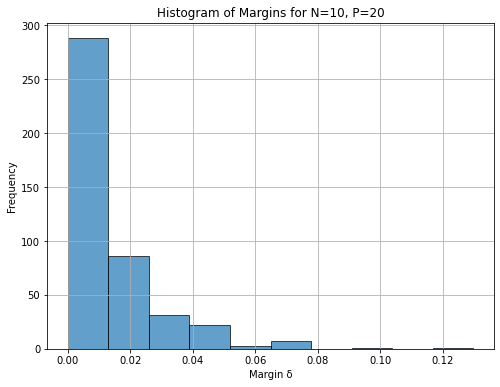

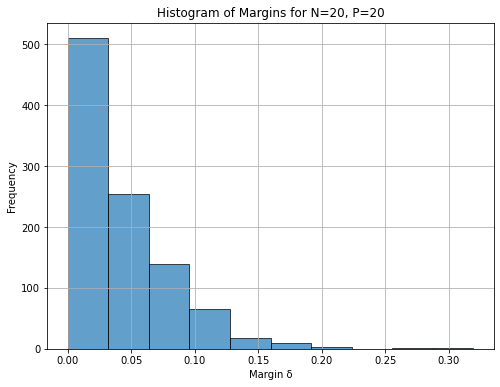

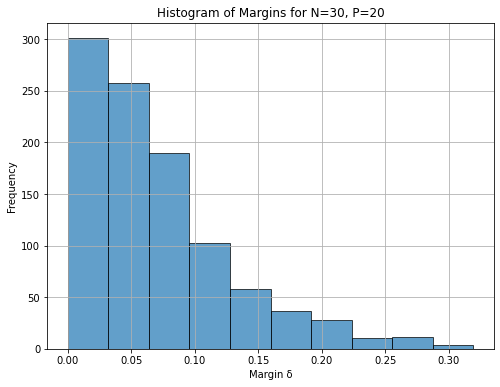

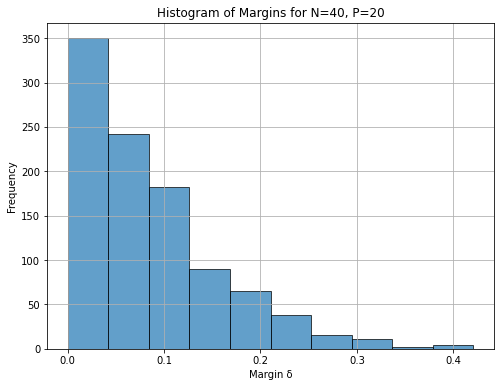

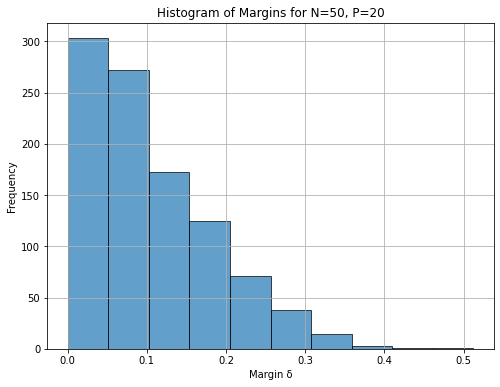

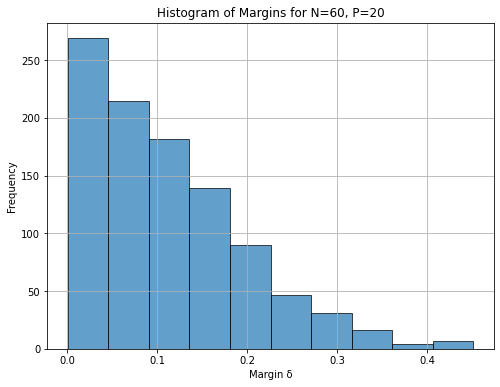

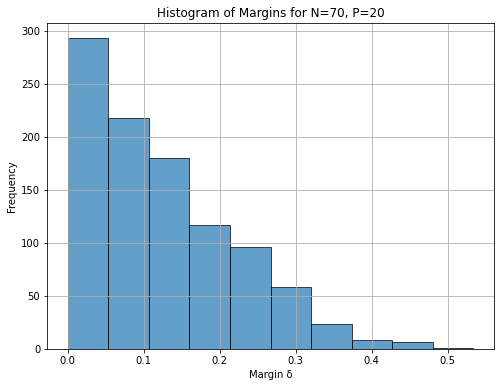

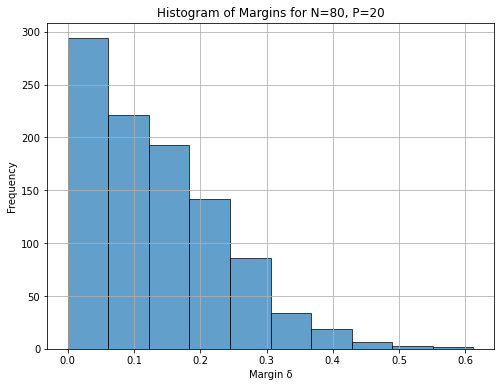

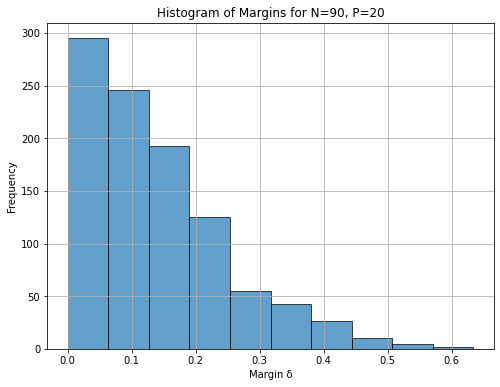

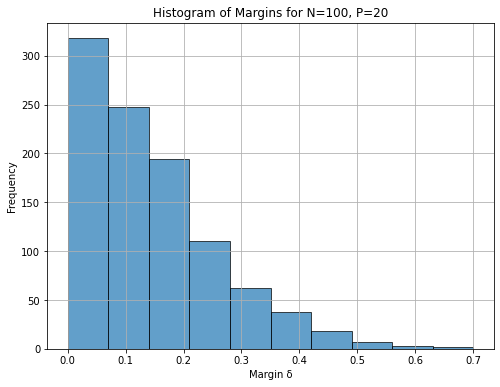

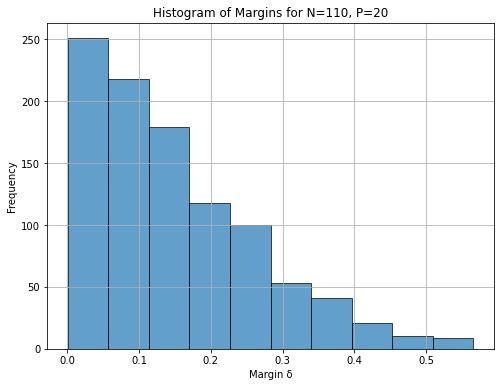

In [121]:
# Run experiments
margins_dict = run_experiments_with_margins(N_values, P_values, n_repeats, max_epochs)

# Plot histograms
plot_margin_histograms(margins_dict)

In [122]:
# Parameters
N_values = np.arange(100, 200, 10)
P_values = [20]  # P = 0.2N, 0.4N, ..., 2N
n_repeats = 10 ** 3
max_epochs = 1000

N=100, P=20, Converged Runs: 1000/1000
N=110, P=20, Converged Runs: 1000/1000
N=120, P=20, Converged Runs: 1000/1000
N=130, P=20, Converged Runs: 1000/1000
N=140, P=20, Converged Runs: 1000/1000
N=150, P=20, Converged Runs: 1000/1000
N=160, P=20, Converged Runs: 1000/1000
N=170, P=20, Converged Runs: 1000/1000
N=180, P=20, Converged Runs: 1000/1000
N=190, P=20, Converged Runs: 1000/1000


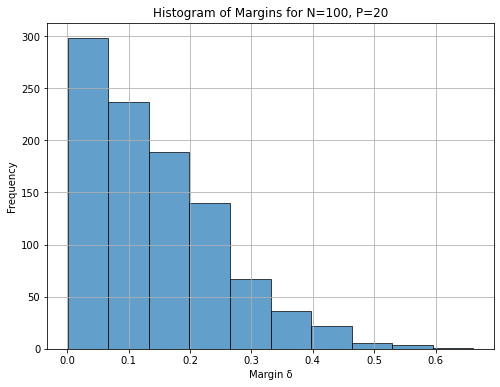

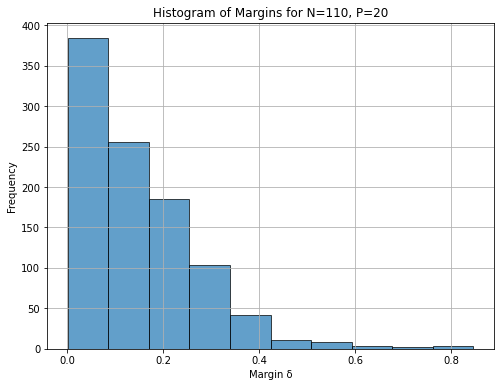

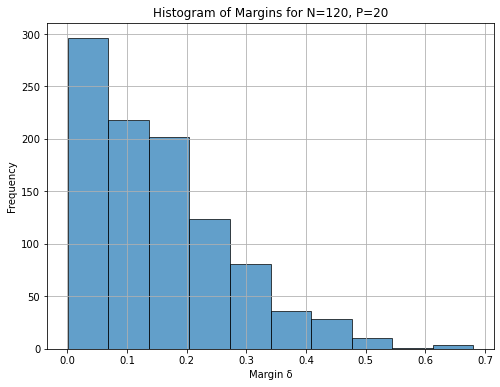

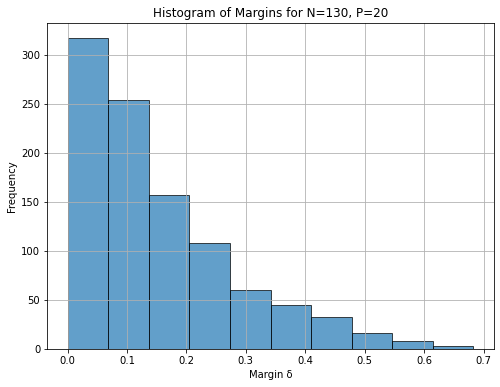

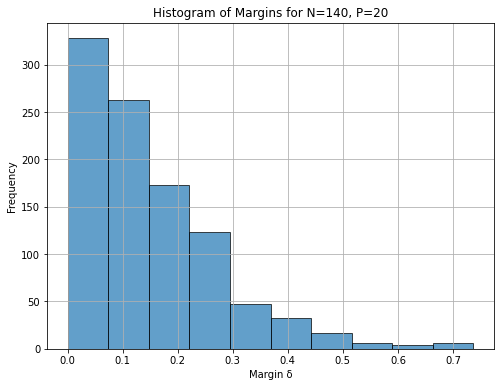

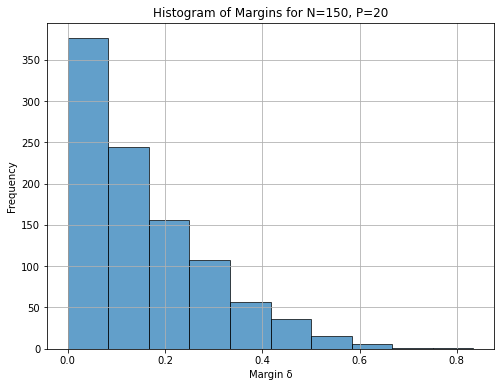

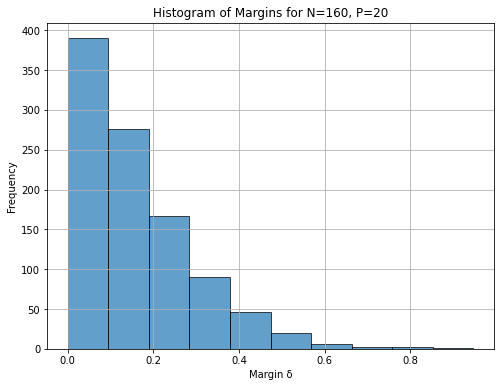

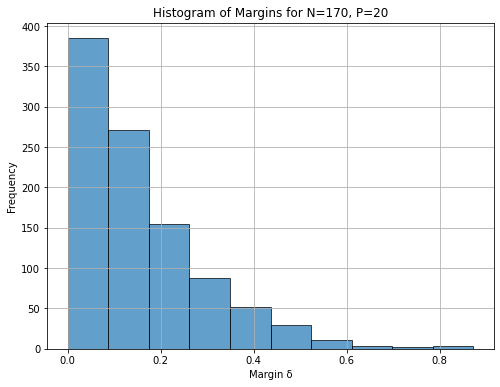

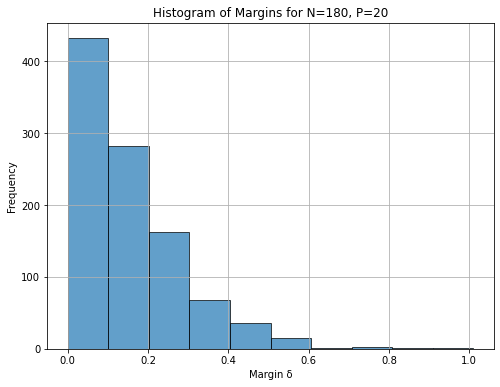

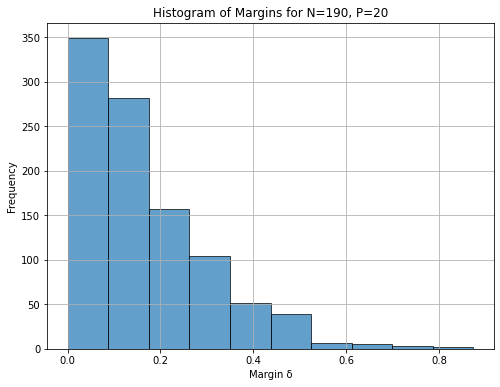

In [123]:
# Run experiments
margins_dict = run_experiments_with_margins(N_values, P_values, n_repeats, max_epochs)

# Plot histograms
plot_margin_histograms(margins_dict)